Data shape: (4269, 13)
Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values per column:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Basic statistics for numeric columns:
           loan_id  no_of_dependents  income_annum   loan_amount    loan_term  \
count  4269.000000       4269.000000  4.269000e+03  4.269000e+03  4269.000000   
mean   2135.000000          2.498712  5.059124e+06  1.513345e+07    10.900445   
std    1232.498479   

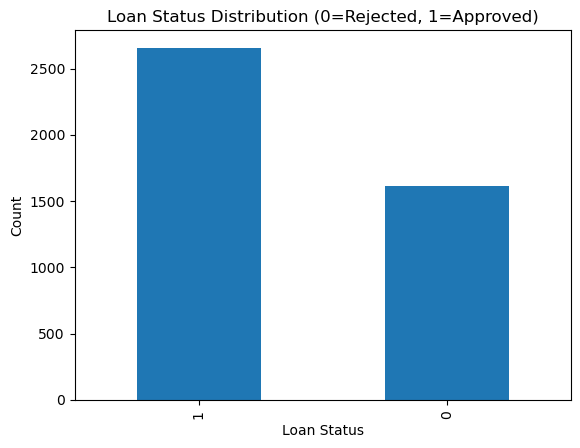

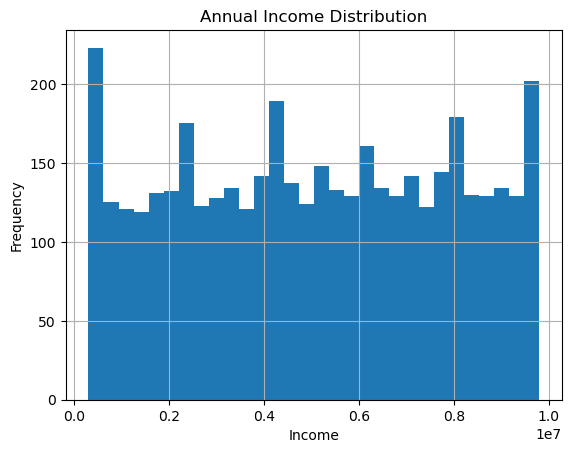

<Figure size 640x480 with 0 Axes>

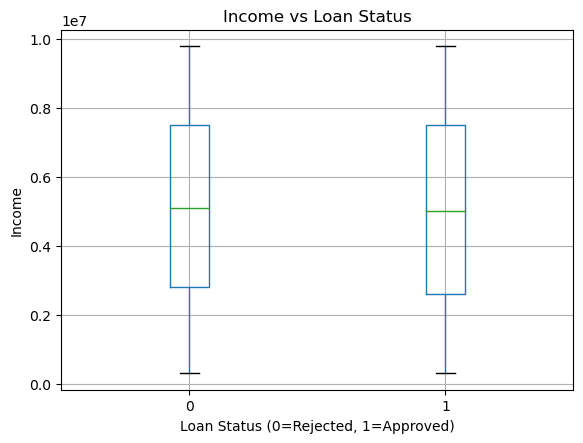

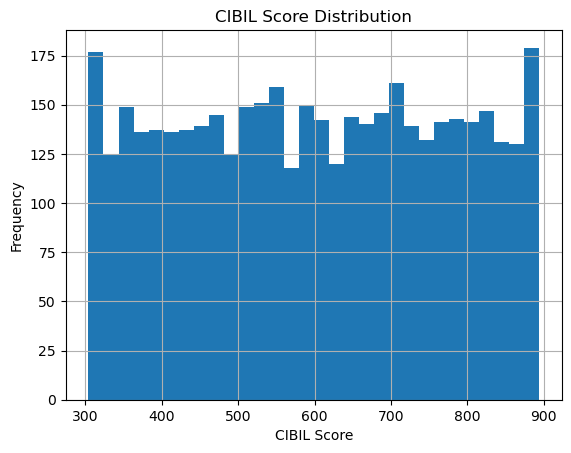

<Figure size 640x480 with 0 Axes>

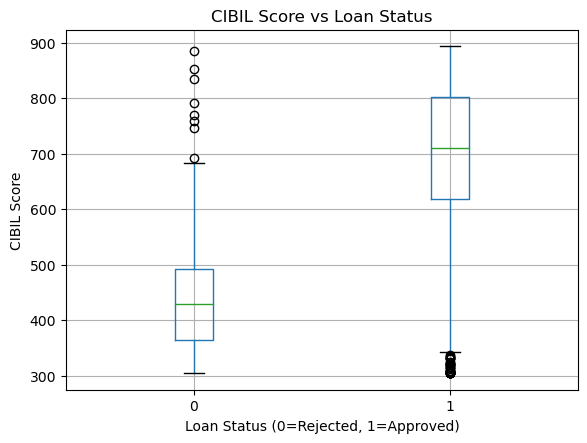

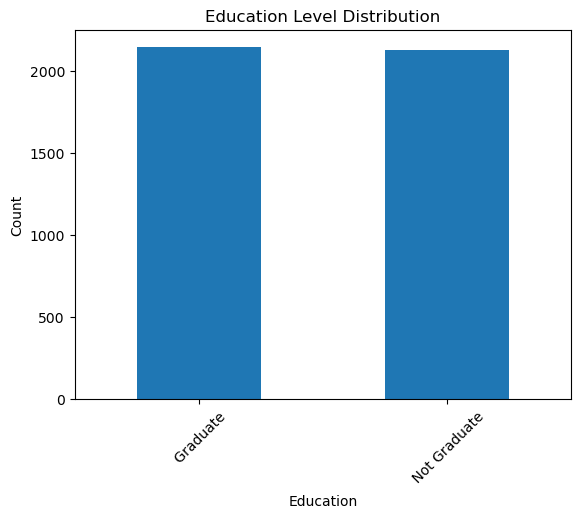

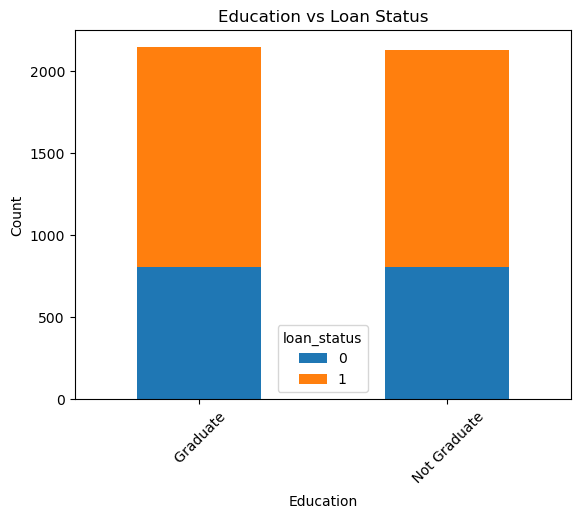

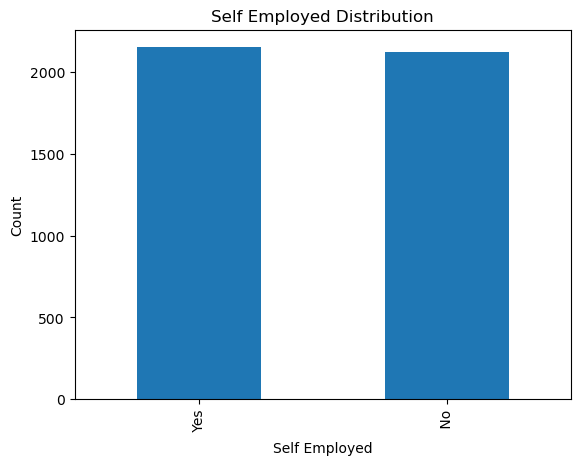

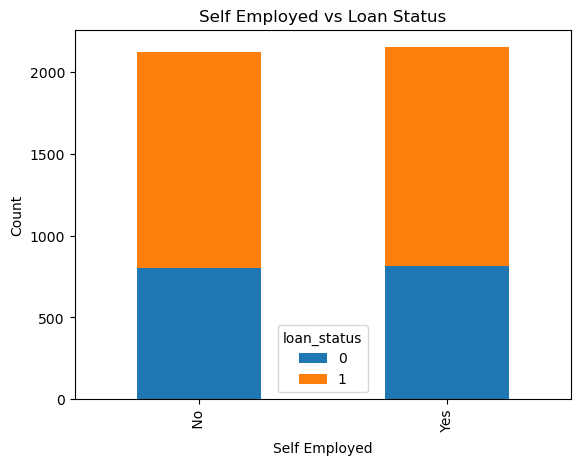

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("loan_approval_dataset.csv")
df.columns = df.columns.str.strip()
print("Data shape:", df.shape)
df.head()
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum())

print("\nBasic statistics for numeric columns:")
print(df.describe())

print("\nUnique values for key categorical columns (if they exist):")
for col in ["education", "self_employed", "loan_status"]:
    if col in df.columns:
        print(f"\nColumn: {col}")
        print(df[col].value_counts(dropna=False))
df["loan_status"] = df["loan_status"].astype(str).str.strip()
print("Unique values in loan_status before mapping:")
print(df["loan_status"].value_counts(dropna=False))
status_map = {"Approved": 1, "Rejected": 0}
df["loan_status"] = df["loan_status"].map(status_map)
df = df.dropna(subset=["loan_status"])
df["loan_status"] = df["loan_status"].astype(int)
print("\nClass distribution after mapping:")
print(df["loan_status"].value_counts())
print("\nClass ratio (Approved / Rejected):")
print(df["loan_status"].value_counts(normalize=True))
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != "loan_status"]

print("Numeric columns:", numeric_cols)
possible_asset_cols = [
    "residential_assets_value",
    "commercial_assets_value",
    "luxury_assets_value",
    "bank_asset_value"
]
for col in possible_asset_cols:
    if col in df.columns:
        print(f"\n{col} - min: {df[col].min()}, max: {df[col].max()}")
for col in numeric_cols:
    if (df[col] < 0).any():
        neg_count = (df[col] < 0).sum()
        print(f"Column '{col}' has {neg_count} negative values (potentially invalid).")
for col in possible_asset_cols:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)
for col in numeric_cols:
    q1 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q1, upper=q99)

print("Finished basic cleaning (negative values & extreme outliers clipped).")
plt.style.use("default")

# ---- Loan status distribution ----
plt.figure()
df["loan_status"].value_counts().plot(kind="bar")
plt.title("Loan Status Distribution (0=Rejected, 1=Approved)")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

# ---- Income distribution ----
if "income_annum" in df.columns:
    plt.figure()
    df["income_annum"].hist(bins=30)
    plt.title("Annual Income Distribution")
    plt.xlabel("Income")
    plt.ylabel("Frequency")
    plt.show()
    plt.figure()
    df.boxplot(column="income_annum", by="loan_status")
    plt.title("Income vs Loan Status")
    plt.suptitle("")  # remove default title
    plt.xlabel("Loan Status (0=Rejected, 1=Approved)")
    plt.ylabel("Income")
    plt.show()

# ---- CIBIL score distribution & relationship ----
if "cibil_score" in df.columns:
    plt.figure()
    df["cibil_score"].hist(bins=30)
    plt.title("CIBIL Score Distribution")
    plt.xlabel("CIBIL Score")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure()
    df.boxplot(column="cibil_score", by="loan_status")
    plt.title("CIBIL Score vs Loan Status")
    plt.suptitle("")
    plt.xlabel("Loan Status (0=Rejected, 1=Approved)")
    plt.ylabel("CIBIL Score")
    plt.show()

# ---- Categorical variables vs loan_status ----
if "education" in df.columns:
    plt.figure()
    df["education"].value_counts().plot(kind="bar")
    plt.title("Education Level Distribution")
    plt.xlabel("Education")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Stacked bar: education vs loan_status
    edu_status = pd.crosstab(df["education"], df["loan_status"])
    edu_status.plot(kind="bar", stacked=True)
    plt.title("Education vs Loan Status")
    plt.xlabel("Education")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

if "self_employed" in df.columns:
    plt.figure()
    df["self_employed"].value_counts().plot(kind="bar")
    plt.title("Self Employed Distribution")
    plt.xlabel("Self Employed")
    plt.ylabel("Count")
    plt.show()

    se_status = pd.crosstab(df["self_employed"], df["loan_status"])
    se_status.plot(kind="bar", stacked=True)
    plt.title("Self Employed vs Loan Status")
    plt.xlabel("Self Employed")
    plt.ylabel("Count")
    plt.show()
